In [103]:
# Importo todas las librerias y funciones que uso en el proceso
from functions import *
# Modifico para poder ver todas las columnas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 15)

In [49]:
# Importo el dataset que generé en el proceso de análisis y los diccionarios de subcategorías para 
# la creación de las nuevas variables

df_final = pickle.load( open( "products_df.sav", "rb" ))
subcat_dict = pickle.load(open('subcat_dict.sav', 'rb'))

In [50]:
# Creo la columna con subcategorias

df_final['subcategory'] = df_final['category_id'].apply(lambda x: subcat_dict[x])

# Construyo las columnas que voy a usar en el modelo

df_final['power_seller_status'] = df_final['seller'].apply(lambda x: x['power_seller_status'])
df_final['real_estate_agency']   = df_final['seller'].apply(lambda x: x['real_estate_agency'])
df_final['car_dealer']          = df_final['seller'].apply(lambda x: x['car_dealer'])
df_final['nick_name']           = df_final['seller'].apply(lambda x: x['eshop']['nick_name'] if 'eshop' in x.keys() else 'NA')
df_final['q_installments']      = df_final['installments'].apply(lambda x: x['quantity'] if x is not None else 'NA')
df_final['state_name']          = df_final['address'].apply(lambda x: x['state_name'])
df_final['city_name']           = df_final['address'].apply(lambda x: x['city_name'])
df_final['free_shipping']       = df_final['shipping'].apply(lambda x: x['free_shipping'])
df_final['logistic_type']       = df_final['shipping'].apply(lambda x: x['logistic_type'])
df_final['store_pick_up']       = df_final['shipping'].apply(lambda x: x['store_pick_up'])
df_final['brand']               = df_final['attributes'].apply(lambda x: x[0]['value_name'] if x != [] else 'NA')

# Descarto las columnas que no se van a usar en el analisis

df_final = df_final[['price','currency_id','available_quantity','sold_quantity','buying_mode'
                     ,'listing_type_id','condition','accepts_mercadopago','original_price','official_store_id'
                     ,'catalog_listing','category','location','sale_terms','subcategory','power_seller_status'
                     , 'real_estate_agency','car_dealer','nick_name','q_installments','state_name','city_name'
                     , 'free_shipping','logistic_type','store_pick_up','brand']]

# Convierto la variable 'installments' en continua y no categorica

df_final['q_installments'] = pd.to_numeric(df_final['q_installments'], errors = 'coerce', 
                                           downcast = 'signed')

### Análisis de NAs

Previo a empezar a hacer un feature engineering, quiero entender la composición de valores nulos que existe en cada variable. En base al análisis previo surge que en algunos casos, un alto porcentaje de nulos no implica que haya que descartar la variable, sino que puede estar indicando un comportamiento (si el producto tiene o no descuento, por ejemplo).

In [51]:
(df_final.isna().sum()/len(df_final))*100

price                 2.179915
currency_id           2.179915
available_quantity    0.000000
sold_quantity         0.000000
buying_mode           0.000000
                        ...   
city_name             0.000000
free_shipping         0.000000
logistic_type         3.817015
store_pick_up         0.000000
brand                 1.227492
Length: 26, dtype: float64

Algunos puntos a analizar:

* El hecho de que falte el valor de *price* no tiene sentido, porque todo producto que se publique tiene que tener un precio, exceptuando que sea alguna categoría particular
* Que la condición sea nula es raro, pero no es un porcentaje muy alto
* Como se menciono anteriormente, un valor nulo en *original_price* no es un error, sino que indica que el producto no tiene descuento, pueden tratarse los nulos, ya sea creando una columna que indique si tiene descuento o no, y otra que indique el porcentaje de descuento
* *official_store_id* nulo puede indicar que no tiene tienda oficial
* *catalog_listing* tiene muchos nulos, puede considerarse eliminarse
* *location* tiene un alto porcentaje de nulos, y puede reemplazarse esta información por las columnas *city_name* y *state_name*
* *sale_terms* tiene muchos nulos que no pueden imputarse
* *power_seller_status* da información útil sobre la clasificación del vendedor, se puede buscar la forma de tratar los nulos
* *q_installments* nulo puede indicar que el producto no tiene cuotas o ser un error, de cualquier forma, son pocos
* *logistic_type* y *brand* tienen baja proporción de nulos, podrían eliminarse o tratarse

### Consideración de variables

En esta parte se analizan las variables que deben ir en el modelo y cuáles se descartan (todavía no se está haciendo ninguna ingeniería de atributos)

In [52]:
df_final.describe()

,price,available_quantity,sold_quantity,q_installments
count,2.937410e+05,300287.000000,300287.000000,273743.000000
mean,5.087114e+04,704.375457,90.270864,11.547386
std,2.115941e+06,5089.644085,413.857106,1.912969
min,1.000000e+00,1.000000,0.000000,6.000000
25%,4.490000e+02,1.000000,5.000000,12.000000
50%,1.266000e+03,1.000000,25.000000,12.000000
75%,3.990000e+03,50.000000,100.000000,12.000000
max,1.111111e+09,50000.000000,50000.000000,18.000000


In [53]:
df_final[df_final['price'].isna()]['category'].value_counts()

Servicios    6546
Name: category, dtype: int64

In [54]:
# Veo los valores posibles de currency_id, si tiene varios, se mantiene pero si todos los precios están 
# en pesos, no vale la pena mantenerla

df_final['currency_id'].value_counts()

ARS    288283
USD      5458
Name: currency_id, dtype: int64

Vemos que hay de ambas monedas, lo que seguramente influirá al momento de la cantidad de productos comprados, por lo que se mantiene esta variable

In [55]:
df_final['buying_mode'].value_counts()

buy_it_now    270402
classified     29885
Name: buying_mode, dtype: int64

In [56]:
df_final['listing_type_id'].value_counts()

gold_special    240826
gold_pro         29460
gold_premium     26631
gold              1854
silver            1400
free               116
Name: listing_type_id, dtype: int64

In [57]:
df_final['condition'].value_counts()

new              270624
used              17509
not_specified      2154
Name: condition, dtype: int64

In [58]:
df_final['accepts_mercadopago'].value_counts()

True     290171
False     10116
Name: accepts_mercadopago, dtype: int64

In [59]:
df_final['power_seller_status'].value_counts()

platinum    125737
gold         38235
silver       22348
Name: power_seller_status, dtype: int64

In [60]:
df_final['real_estate_agency'].value_counts()

False    297062
True       3225
Name: real_estate_agency, dtype: int64

In [61]:
df_final['car_dealer'].value_counts()

False    292176
True       8111
Name: car_dealer, dtype: int64

In [62]:
df_final['q_installments'].value_counts()

12.0    244359
6.0      25017
18.0      4367
Name: q_installments, dtype: int64

In [63]:
df_final['free_shipping'].value_counts()

False    220027
True      80260
Name: free_shipping, dtype: int64

In [64]:
df_final['logistic_type'].value_counts()

cross_docking    120492
drop_off          55808
xd_drop_off       44998
not_specified     43921
fulfillment       18940
custom             4621
default              45
Name: logistic_type, dtype: int64

In [65]:
df_final['store_pick_up'].value_counts()

False    292184
True       8103
Name: store_pick_up, dtype: int64

### Tratado de variables

Se crean nuevas variables necesarias para el tratamiento de algunos nulos, se eliminan aquellas que tienen un alto porcentaje y no pueden tratarse

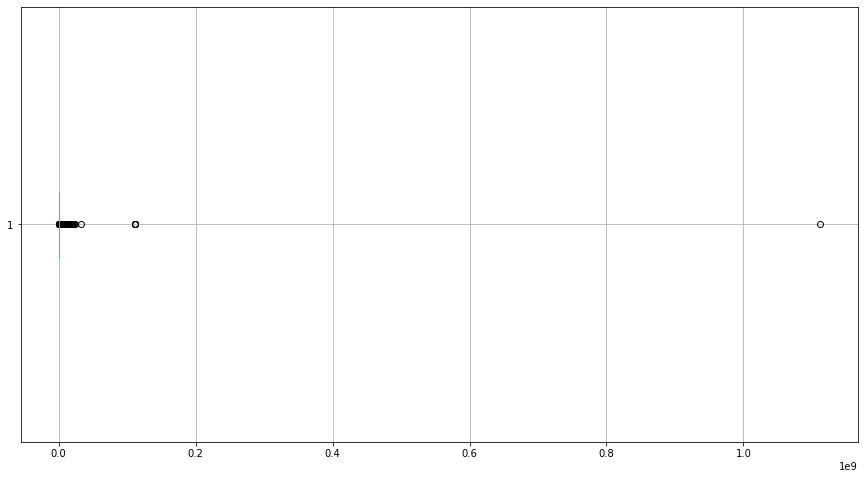

In [66]:
plt.figure(figsize = (15,8))
plt.boxplot(df_final[df_final['price'].notna()]['price'], vert = False)
plt.grid(True)

Se observan varios Outliers en la variable de price (o potenciales Outliers), sin embargo, la idea es ver por qué valor se puede imputar a los valores nulos, ya que en estos casos no es un error sino que, como se vio previamente, se puede intuir que para algunos servicios, no se coloca precio al producto/servicio.

Un valor razonable es el -1, ya que no existen precios negativos.

In [67]:
df_final['price'] = df_final['price'].fillna(-1)

Para reemplazar los nulos en la variable *currency_id* se mira primero en qué categorías se tiene la moneda en *USD*, porque la mayoría está en *ARS*, y ver si se dan siempre en la misma categoría

In [68]:
df_final[df_final['currency_id'] == 'USD']['category'].value_counts()

Inmuebles               3825
Autos, Motos y Otros    1565
Servicios                 68
Name: category, dtype: int64

Los valores nulos de la variable son los mismos registros que tenían la variable *price* nula, lo cual es lógico, al no haber precio, no indica el currency. 

También se había visto que todos los nulos de *price* se encontraban en la categoría *servicios*. Por lo tanto, viendo que los servicios que se cobran en dólares son la minoría, se asume que los valores *NA* del currency son *ARS*

In [69]:
df_final['currency_id'] = df_final['currency_id'].fillna('ARS')

Los nulos para la *condition* se toma como criterio colocar el valor *not_specified*, que ya es un valor posible dentro del dataset

In [70]:
df_final['condition'] = df_final['condition'].fillna('not_specified')

### Creo la variable 'with_discount' y 'discount'

Se va a mantener la variable *original_price*, agregando una categórica que indique si el producto tiene descuento o no, y otra que tenga el porcentaje de descuento.

Cuando se esté testeando el modelo en la etapa de validación, se demostrará si vale la pena mantener la variable original o no

In [71]:
# Creo la variable 'with_discount' indicando si el producto tiene descuento o no

df_final['with_discount'] = df_final['original_price'].notna()

In [72]:
# Reemplazo los NANs de 'original_price' por el valor de price (0% de descuento) y creo
# la variable % de descuento, calculando la relación entre original price y price

df_final['original_price'] = df_final['original_price'].fillna(df_final['price'])
df_final['descuento'] = ((df_final['original_price'] - df_final['price'])/df_final['original_price'])*100

### Variable 'power_seller_status'

Los más probable es que los valores nulos que se encuentran sean porque el vendedor no tenga una clasificación muy alta, probablemente por sus bajas ventas, que lleva a no muchas calificaciones positivas, etc.

In [73]:
df_final['power_seller_status'].value_counts()

platinum    125737
gold         38235
silver       22348
Name: power_seller_status, dtype: int64

In [74]:
df_final[df_final['power_seller_status'].isna()]['sold_quantity'].value_counts()

0        31462
5        26010
25       13595
50       11196
1         6414
100       5012
2         4260
250       3675
3         2838
150       2779
500       2697
4         2184
200       1775
5000        69
50000        1
Name: sold_quantity, dtype: int64

Vemos que los casos que tienen nulo el valor de la variable *power_seller_satatus* no han vendido más de 1000 unidades, sino que suelen tener pocos artículos vendidos. 

En base a esta información, podemos reemplazar el valor de los *NAs* por una valor tipo *'basic'*

In [75]:
df_final['power_seller_status'] = df_final['power_seller_status'].fillna('basic')

### Variable 'q_installments'

Los valores nulos en estos casos pueden tratarse de artículos que no ofrecen cuotas, por lo que se reemplaza por un 0

In [76]:
df_final['q_installments'] = df_final['q_installments'].fillna(0)

### Variables 'logistic_type' y 'brand'

In [77]:
df_final['logistic_type'].value_counts()

cross_docking    120492
drop_off          55808
xd_drop_off       44998
not_specified     43921
fulfillment       18940
custom             4621
default              45
Name: logistic_type, dtype: int64

In [78]:
df_final['brand'].value_counts()

Nuevo                 35487
NA                    10219
Usado                  9793
No                     5029
Sí                     4199
                      ...  
Edicion Especial          1
Teriyaki                  1
ARTECOR DECORACION        1
Pawz                      1
100-208                   1
Name: brand, Length: 40205, dtype: int64

Para los casos nulos de la variable *logistic_type*, en vista de que existe el valor *default*, se reemplazara por este valor.

El caso de la *brand*, no se obtuvo adecuadamente el valor, sino que hay una mezcla de atributos, por lo que no puede utilizarse esta variable

In [79]:
df_final['logistic_type'] = df_final['logistic_type'].fillna('default')

## Me quedo con el dataframe final

In [80]:
df_final = df_final[['price','currency_id','available_quantity','sold_quantity','buying_mode'
                     ,'listing_type_id','condition','accepts_mercadopago','original_price'
                     ,'category','subcategory','power_seller_status'
                     , 'real_estate_agency','car_dealer','q_installments','state_name','city_name'
                     , 'free_shipping','logistic_type','store_pick_up','with_discount','descuento']]

## Validación del modelo - Train/ Test Split

En esta etapa separo un conjunto de testeo (o validación) para poder evaluar la performance del modelo sobre datos nuevos.

El modelo que se va a desarrollar es uno de *clasificación*, ya que si bien la variable a predecir es continua, en las bases se encuentra discretizada en rangos.

In [81]:
# # Uso el diccionario generado en la etapa de análisis para convertir los valores continuos en categoricos

# dict_sold = pickle.load(open('dict_sold.sav', 'rb'))

# # Creo una columna con el rango de productos vendidos

# df_final['sold_quantity_range'] = df_final['sold_quantity'].apply(lambda x: dict_sold[str(x)])

In [82]:
# # Elimino la variable original, ya no la necesito

# df_final.drop(columns = 'sold_quantity_range', axis = 1, inplace = True)

Antes de dividir también es importante detectar outliers que puedan desviar los resultados

In [83]:
df_final.describe()

,price,available_quantity,sold_quantity,original_price,q_installments,descuento
count,3.002870e+05,300287.000000,300287.000000,3.002870e+05,300287.000000,300287.000000
mean,4.976217e+04,704.375457,90.270864,4.989899e+04,10.526650,1.496312
std,2.092764e+06,5089.644085,413.857106,2.092764e+06,3.752458,6.067447
min,-1.000000e+00,1.000000,0.000000,-1.000000e+00,0.000000,0.000000
25%,4.000000e+02,1.000000,5.000000,4.100000e+02,12.000000,-0.000000
50%,1.200000e+03,1.000000,25.000000,1.208790e+03,12.000000,0.000000
75%,3.898390e+03,50.000000,100.000000,3.999000e+03,12.000000,0.000000
max,1.111111e+09,50000.000000,50000.000000,1.111111e+09,18.000000,94.410000


Unicamente pareciera haber valores aberrantes en el *price*. Tiene un máximo muy extremo. Podemos verificar a qué tipo de producto pertenece

In [84]:
df_final.loc[df_final['price'] > df_final['price'].quantile(0.95)]

,price,currency_id,available_quantity,sold_quantity,buying_mode,listing_type_id,condition,accepts_mercadopago,original_price,category,subcategory,power_seller_status,real_estate_agency,car_dealer,q_installments,state_name,city_name,free_shipping,logistic_type,store_pick_up,with_discount,descuento
18,76120.0,ARS,1,4,buy_it_now,gold_pro,new,True,76120.0,Accesorios para Vehículos,Aspiradoras,platinum,False,False,6.0,Capital Federal,Villa Crespo,True,cross_docking,False,False,0.0
3489,76900.0,ARS,1,25,buy_it_now,gold_special,new,True,76900.0,Accesorios para Vehículos,Kits de Embrague,silver,False,False,12.0,Buenos Aires,Adrogue,True,drop_off,False,False,0.0
9320,69000.0,ARS,500,25,buy_it_now,gold_pro,new,True,69000.0,Accesorios para Vehículos,Equipos Completos,silver,False,False,18.0,Capital Federal,Nueva Pompeya,False,not_specified,False,False,0.0
9642,66600.0,ARS,500,25,buy_it_now,gold_pro,new,True,66600.0,Accesorios para Vehículos,Equipos Completos,silver,False,False,18.0,Capital Federal,Nueva Pompeya,False,not_specified,False,False,0.0
9768,72000.0,ARS,500,5,buy_it_now,gold_pro,new,True,72000.0,Accesorios para Vehículos,Equipos Completos,silver,False,False,18.0,Capital Federal,Parque Patricios,False,not_specified,False,False,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294924,110000.0,ARS,1,5,buy_it_now,gold_special,new,True,110000.0,Otras categorías,Otros,gold,False,False,12.0,Santa Fe,Villa Amelia,True,drop_off,False,False,0.0
296527,65000.0,ARS,1,1,buy_it_now,gold_special,new,True,65000.0,Otras categorías,Otros,basic,False,False,12.0,Capital Federal,Palermo,True,not_specified,False,False,0.0
298984,139000.0,ARS,1,0,buy_it_now,gold_pro,new,True,139000.0,Otras categorías,Rigs Mineros,basic,False,False,6.0,Capital Federal,Palermo,False,not_specified,False,False,0.0
299256,84600.0,ARS,50,2,buy_it_now,gold_special,new,True,84600.0,Otras categorías,Pirotecnia,gold,False,False,12.0,Capital Federal,Capital Federal,False,not_specified,False,False,0.0


Cuando se buscaron estos productos, todos parecían tener el precio adecuado. Lo que se notó fue que todos eran productos de autos o más industriales, por lo que su precio es elevado.

Lógicamente, cuando se mira la cantidad de productos vendidos, suelen ser valores muy bajos o nulos. Sin embargo, se mantienen estos registros porque son datos correctos

Me fijo cómo están distribuidas las clases a predecir, si están balanceadas o hay más cantidad de registros de una que de otras

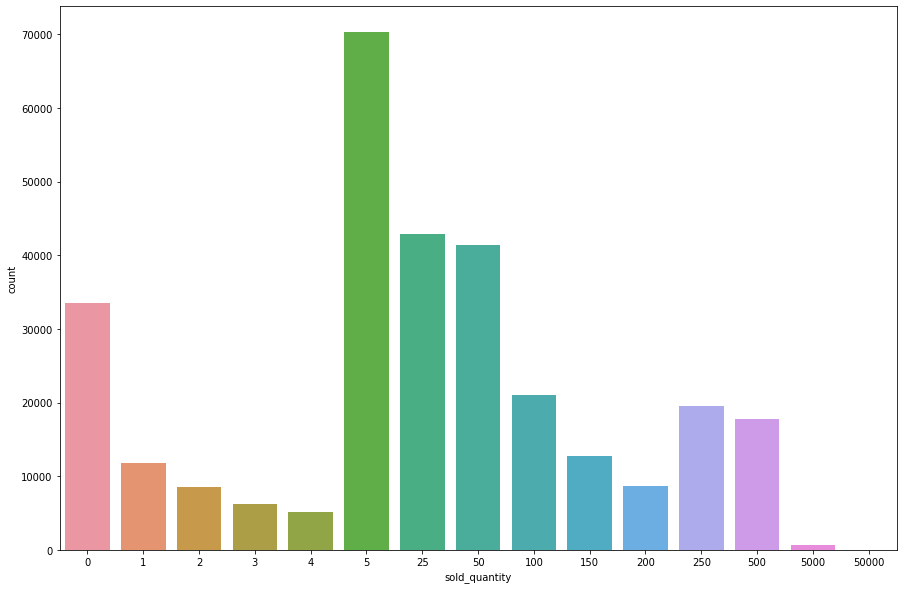

In [85]:
# Grafico el balance de las clases

plt.figure(figsize = (15,10))
sns.countplot(df_final['sold_quantity'])

Se ve que hay más casos de 5,0,25 y 50 que de las demás, esto puede traer un problema al momento del modelado porque las clases están levemente desbalanceadas

In [86]:
# Separo en train y test
# Nota: Debido a que la subcategoria tiene muchos niveles, se lo va a clasificar con un código numerico

le = preprocessing.LabelEncoder()
df_final['subcategory'] = le.fit_transform(df_final['subcategory'])

Debido al desbalanceo de las clases, se optó por una *'primera aproximación'* que fue redefinir las clases a predecir, pasando de tener todos los rangos de cantidades que existen a tener solamente 4 rangos de cantidades vendidas, separados en base a los cuantiles.

Si bien esta clasificación no es la que originalmente está en la web, tener tantas clases reducía la performance significativamente, y se resolvió de esta forma en vistas de que en un proyecto, este podría ser un primer entregable o un mínimo producto viable que puede ser consumible.

Futuras etapas implicarían la mejora del modelo final que se presentará, de manera tal de lograr predecir más rangos.

In [87]:
# Separo en cuantiles la variable target

df_final['target'] = df_final['sold_quantity'].apply(lambda x: 0 if x<5 else (1 if x<25 else (2 if x<100 else 3)))

In [88]:
# Separo en train y test
# Algunas de las variables que se excluyeron del modelo se hicieron previamente habiendo evaluado el modelo
# en validacion, obteniendo ninguna mejora o inclusive reduciendo la performance
# Guardo las variables descriptivas y hago OHE para obtener variables numericas 

X = df_final.drop(columns = ['descuento','original_price','subcategory','state_name','city_name','sold_quantity','target'], axis = 1)
X = pd.get_dummies(X)
keep_columns = X.columns
# Algunas transformaciones
# Debido a lo concentrados que estaban los precios en los valores bajos, se aplica una log transform
# sobre los precios
X['price'] = np.log(X['price'] + 1 - min(X['price']))
# Guardo las variables a predecir
y = df_final['target']
classes = y.unique()

# Separo en conjunto de testeo y validacion
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.23, random_state = 42)

# Normalizo (validado en conjunto de testeo)
normalizer = StandardScaler()
X_train = normalizer.fit_transform(X_train)
X_test = normalizer.transform(X_test)

X_train = pd.DataFrame(X_train, columns=keep_columns)
X_test = pd.DataFrame(X_test, columns=keep_columns)

In [89]:
# Elimino variables correlacionadas

del_var = corr_elimination(X_train, max_corr = 0.8)
X_train = X_train.drop(labels = del_var, axis = 1)
X_test  = X_test.drop(labels  = del_var, axis = 1)

# Elimino variables poco relevantes

del_var = forest_elimination(X_train, y_train, total = 5)
X_train = X_train.drop(labels = [*del_var,'random'], axis = 1)
X_test  = X_test.drop(labels  = del_var, axis = 1)

Se eliminaron 6 de 64 variables.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 50building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50

building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50building tree 11 of 50

building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50building tree 23 of 50

building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50

[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.7s



building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.9s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 50building tree 2 of 50

building tree 3 of 50
building tree 4 of 50building tree 5 of 50

building tree 6 of 50building tree 7 of 50
building tree 8 of 50

building tree 9 of 50
building tree 10 of 50building tree 11 of 50

building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50building tree 18 of 50

building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.7s


building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50building tree 42 of 50

building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.9s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 50building tree 2 of 50

building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50

[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.7s



building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.9s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 50building tree 2 of 50
building tree 3 of 50
building tree 4 of 50

building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50building tree 18 of 50

building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.7s


building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    2.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 50building tree 2 of 50

building tree 3 of 50building tree 4 of 50

building tree 5 of 50building tree 6 of 50
building tree 7 of 50

building tree 8 of 50
building tree 9 of 50
building tree 10 of 50building tree 11 of 50

building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.7s


building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50building tree 48 of 50

building tree 49 of 50
building tree 50 of 50


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    2.1s finished


                                feacture  ranking
0                          condition_new      0.0
1                         q_installments      1.0
2           listing_type_id_gold_premium      2.0
3                         condition_used      3.0
4           listing_type_id_gold_special      4.0
..                                   ...      ...
54  category_Salud y Equipamiento Médico     54.0
55            category_Juegos y Juguetes     55.0
56                  logistic_type_custom     56.0
57                        category_Bebés     57.0
58                  listing_type_id_free     58.0

[59 rows x 2 columns]
Se eliminaron 8 de 58 variables.


## Logistic Regression

In [49]:
# Creo elemento LogisticRegression y fiteo sobre los datos de entrenamiento 

clf = LogisticRegression(solver='sag', max_iter=100, random_state=42,
                             multi_class = 'multinomial').fit(X_train, y_train)

# Evaluo el desempeño en train y test
print("training score : %.3f (%s)" % (clf.score(X_train, y_train), 'multinomial'))

C:\Users\elosasso\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


training score : 0.376 (multinomial)


# Random Forest

In [90]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 200, criterion = 'entropy', random_state = 0
                                    ,max_depth = 22)
# Entreno el modelo
classifier.fit(X_train, y_train)

# Hago una prediccion
y_pred = classifier.predict(X_test)

# Creo la matriz de confusion
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred, labels = classes)


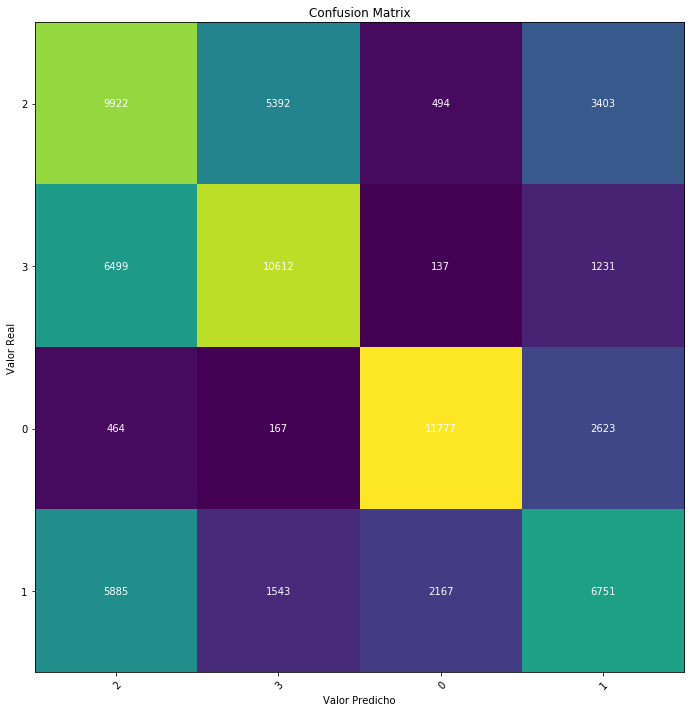

In [91]:
# Visualizo matriz de confusion

plot_CM(cm,classes)

In [93]:
# Evaluacion del modelo según metricas más comunes 

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.78      0.80     15031
           1       0.48      0.41      0.44     16346
           2       0.44      0.52      0.47     19211
           3       0.60      0.57      0.59     18479

    accuracy                           0.57     69067
   macro avg       0.58      0.57      0.57     69067
weighted avg       0.57      0.57      0.57     69067



# Neural Network

In [95]:
# Creamos el modelo.
Class_NNmodel = Class_nn_model(X_train,12,None,None)
# Estructura de mi modelo.
Class_NNmodel.summary()

# Entrenamiento del modelo.

# Definimos las épocas y el batch de entrenamiento.  
EPOCHS     = 200
batch_size = None

# Genero las variables categoricas del target.
# ej: si es clase 2 --> [0,1,0,0]
y_train = pd.get_dummies(y_train.astype(str))
y_test  = pd.get_dummies(y_test.astype(str))

# Entrenamos nuestro modelo.
history = Class_NNmodel.fit(
          X_train, y_train,
          epochs=EPOCHS, verbose=2,
          batch_size=batch_size,
          # Con esto le puedo dar mas pesos a unos targets que otros.
          # Es util para targets desbalanceados.
          class_weight = {0: 1., 1: 1., 2: 1., 3: 1.}, 
#           class_weight = {0: weight[0], 1: weight[1], 2: weight[2], 3: weight[3]},
          validation_split=0.2)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 12)                612       
_________________________________________________________________
dropout_2 (Dropout)          (None, 12)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 52        
Total params: 664
Trainable params: 664
Non-trainable params: 0
_________________________________________________________________

Train on 184976 samples, validate on 46244 samples
Epoch 1/200
 - 11s - loss: 0.5305 - acc: 0.7640 - val_loss: 0.4370 - val_acc: 0.7909
Epoch 2/200
 - 10s - loss: 0.4486 - acc: 0.7869 - val_loss: 0.4226 - val_acc: 0.7944
Epoch 3/200
 - 10s - loss: 0.4394 - acc: 0.7886 - val_loss: 0.4188 - val_acc: 0.7947
Epoch 4/200
 - 11s - loss: 0.4359 - acc: 0.7889 - val_loss: 0.4172 - val_acc: 0

Epoch 85/200
 - 10s - loss: 0.4304 - acc: 0.7891 - val_loss: 0.4136 - val_acc: 0.7954
Epoch 86/200
 - 10s - loss: 0.4305 - acc: 0.7890 - val_loss: 0.4137 - val_acc: 0.7955
Epoch 87/200
 - 10s - loss: 0.4310 - acc: 0.7887 - val_loss: 0.4141 - val_acc: 0.7950
Epoch 88/200
 - 10s - loss: 0.4308 - acc: 0.7887 - val_loss: 0.4133 - val_acc: 0.7958
Epoch 89/200
 - 11s - loss: 0.4306 - acc: 0.7891 - val_loss: 0.4134 - val_acc: 0.7954
Epoch 90/200
 - 10s - loss: 0.4310 - acc: 0.7887 - val_loss: 0.4135 - val_acc: 0.7955
Epoch 91/200
 - 10s - loss: 0.4307 - acc: 0.7887 - val_loss: 0.4136 - val_acc: 0.7955
Epoch 92/200
 - 10s - loss: 0.4309 - acc: 0.7887 - val_loss: 0.4136 - val_acc: 0.7952
Epoch 93/200
 - 10s - loss: 0.4302 - acc: 0.7891 - val_loss: 0.4137 - val_acc: 0.7952
Epoch 94/200
 - 11s - loss: 0.4306 - acc: 0.7891 - val_loss: 0.4136 - val_acc: 0.7953
Epoch 95/200
 - 10s - loss: 0.4307 - acc: 0.7888 - val_loss: 0.4135 - val_acc: 0.7954
Epoch 96/200
 - 10s - loss: 0.4306 - acc: 0.7889 - val

 - 9s - loss: 0.4307 - acc: 0.7892 - val_loss: 0.4138 - val_acc: 0.7954
Epoch 181/200
 - 9s - loss: 0.4307 - acc: 0.7891 - val_loss: 0.4137 - val_acc: 0.7952
Epoch 182/200
 - 9s - loss: 0.4307 - acc: 0.7886 - val_loss: 0.4136 - val_acc: 0.7952
Epoch 183/200
 - 9s - loss: 0.4310 - acc: 0.7889 - val_loss: 0.4138 - val_acc: 0.7951
Epoch 184/200
 - 9s - loss: 0.4304 - acc: 0.7891 - val_loss: 0.4134 - val_acc: 0.7952
Epoch 185/200
 - 9s - loss: 0.4310 - acc: 0.7891 - val_loss: 0.4137 - val_acc: 0.7950
Epoch 186/200
 - 9s - loss: 0.4304 - acc: 0.7888 - val_loss: 0.4135 - val_acc: 0.7955
Epoch 187/200
 - 9s - loss: 0.4302 - acc: 0.7894 - val_loss: 0.4134 - val_acc: 0.7953
Epoch 188/200
 - 9s - loss: 0.4307 - acc: 0.7889 - val_loss: 0.4136 - val_acc: 0.7954
Epoch 189/200
 - 9s - loss: 0.4311 - acc: 0.7889 - val_loss: 0.4138 - val_acc: 0.7951
Epoch 190/200
 - 9s - loss: 0.4312 - acc: 0.7887 - val_loss: 0.4138 - val_acc: 0.7950
Epoch 191/200
 - 9s - loss: 0.4310 - acc: 0.7889 - val_loss: 0.4137 

In [102]:
# Guardamos el modelo entrenado para utilizarlo en el futuro.

Class_NNmodel.save("nn_model.h5")

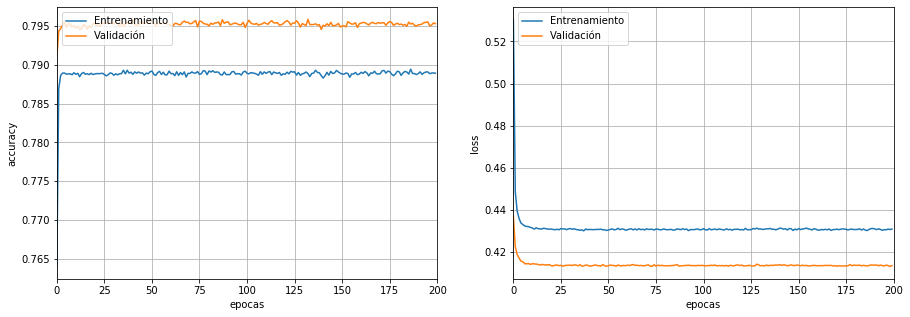

In [96]:
# Mostramos el entrenamiento del modelo.

f, axes = plt.subplots(1, 2, figsize = (15,5))

# Accuracy para cada epoca de entrenamiento.
axes[0].plot(history.history['acc'])
axes[0].plot(history.history['val_acc'])
axes[0].set_ylabel('accuracy')
axes[0].set_xlabel('epocas')
axes[0].legend(['Entrenamiento', 'Validación'], loc='upper left')
axes[0].set_xlim([0, EPOCHS])
axes[0].grid()

# Funcion de perdida para cada epoca de entrenamiento.
axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'])
axes[1].set_ylabel('loss')
axes[1].set_xlabel('epocas')
axes[1].legend(['Entrenamiento', 'Validación'], loc='upper left')
axes[1].set_xlim([0, EPOCHS])
axes[1].grid()

Text(570.5454545454544, 0.5, 'true')

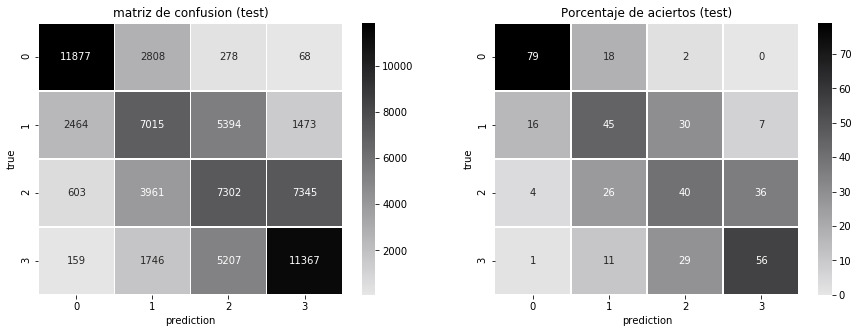

In [97]:
y_pred  = Class_NNmodel.predict(X_test)
y_pred  = (y_pred-0).argmax(axis=1)   
y_test2 = np.array(y_test).argmax(axis=1)

f, axes = plt.subplots(1, 2, figsize = (15,5))

cm   = confusion_matrix(y_test2, y_pred)
cmap = sns.cubehelix_palette(50, hue=0.05, rot=0, light=0.9, dark=0, as_cmap=True)
sns.heatmap(cm, annot=True, linewidths=.5, cmap=cmap, fmt='d', ax = axes[0])
axes[0].set_title('matriz de confusion (test)')
axes[0].set_xlabel('prediction')
axes[0].set_ylabel('true')

cm2   = np.round(cm/cm.sum(axis = 0)*100, 0).astype(int)
cmap = sns.cubehelix_palette(50, hue=0.05, rot=0, light=0.9, dark=0, as_cmap=True)
sns.heatmap(cm2, annot=True, linewidths=.5, cmap=cmap, fmt='d', ax = axes[1])
axes[1].set_title('Porcentaje de aciertos (test)')
axes[1].set_xlabel('prediction')
axes[1].set_ylabel('true')



C:\Users\elosasso\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


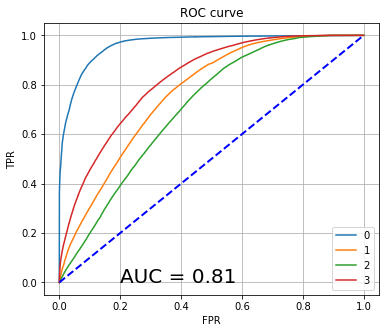

In [101]:
# Generamos la curva ROC.

ROC_curve(Class_NNmodel, X_train, y_train)

# Conlusión

Está claro, en base a los resultados obtenidos, que el modelo que obtuvo mejores resultados fue el de la red neuronal. La medida utilizada para determinar esto fue la AUC, y aunque los datos que se ingresaron a la red no eran distintos de los que se utilizaron en el *Random Forest*, claramente la red aprendió a detectar patrones que el otro modelo no.

Aún así, el modelo de *Random Forest* tenía espacio para mejoras que podrían levantar la performance (que se midió con la matriz de confusión y principalmente el f1-score.

El peor de los modelos fue el de la *Regresión Logística*. Si bien es un modelo simple, no estaba de más intentar un modelo así.

# Comentarios finales

Como se mencionó anteriormente, esta es una primera aproximación a la solución final. Restarían más pasos que tendrían como objetivo mejorar la performance de la red (probando distintos hiperparámetros, más capas, distintas configuraciones, etc.) 

De la misma forma, resta hacer un poco más de ingeniería de atributos, especialmente si se quiere utilizar el *Random Forest* como modelo. Algunas cosas que se quisieron hacer pero no se pudo fueron:

* Hacer un *Análisis de componentes principales* para lograr reducir la dimensionalidad
* Hacer un *Clustering*, previo al entrenamiento de cualquier modelo, para crear una nueva variable que sea el clúster de pertenencia, para evaluar si esa variable extra mejoraría la performance
* Intentar conseguir algunas variables útiles como puede ser la marca de un producto, ya que puede estar relacionada con la cantidad de productos vendidos